In [1]:
import numpy as np
import pandas as pd
import chardet

In [2]:
# Detect the encoding of the CSV file
with open('SQLIV3_cleaned2.csv', 'rb') as f:

    result = chardet.detect(f.read())
# Read the CSV file into a pandas dataframe, using the detected encoding
df = pd.read_csv('SQLIV3_cleaned2.csv', sep=',', encoding=result['encoding'])

df

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
...,...,...
30609,DELETE FROM door WHERE grow = 'small',0
30610,DELETE FROM tomorrow,0
30611,SELECT wide ( s ) FROM west,0
30612,SELECT * FROM ( SELECT slide FROM breath ),0


In [3]:

df.duplicated().sum()

12

In [4]:
# remove duplicates
df = df.drop_duplicates(keep='first')

In [5]:

df.duplicated().sum()

0

In [6]:
df['Label'].value_counts()

Label
0    19260
1    11342
Name: count, dtype: int64

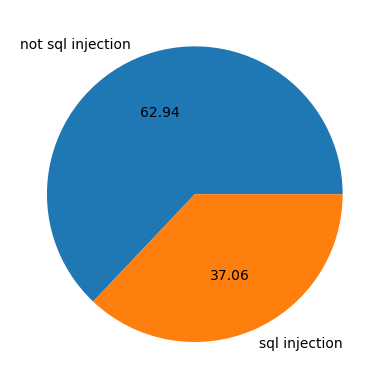

In [7]:
import matplotlib.pyplot as plt
plt.pie(df['Label'].value_counts(), labels=['not sql injection','sql injection'],autopct="%0.2f")
plt.show()

In [8]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [9]:
X = tfidf.fit_transform(df['Sentence']).toarray()

In [10]:
X.shape


(30602, 3000)

In [11]:
y = df['Label'].values


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [14]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [15]:
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(solver='liblinear', penalty='l1')


In [16]:
lrc.fit(X_train,y_train)
y_pred = lrc.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)

In [17]:
print("Accuracy:", accuracy)
print("Precision:", precision)

Accuracy: 0.9812122202254534
Precision: 0.9972640218878249


In [18]:
# Fonction pour prédire si un texte est sqli ou non
def predict_message(message):
       # Preprocess the message
      # Ensure you define this function for text preprocessing
    message_vectorized = tfidf.transform([message]) # Convert to dense array
    prediction = lrc.predict(message_vectorized)  # Make the prediction
    probas = lrc.predict_proba(message_vectorized)  # Get the probabilities
    label = "sql injection" if prediction[0] == 1 else "not sql injection"  # Assign label based on prediction
    return label, probas[0]



In [19]:

import os


# Définition du chemin relatif du fichier CSV
dataset_path = "sqliv2.csv"

# Vérification de l'existence du fichier
if os.path.exists(dataset_path):
    try:
        # Détection de l'encodage du fichier
        with open(dataset_path, 'rb') as f:
            result = chardet.detect(f.read())

        # Lecture du fichier CSV avec l'encodage détecté
        df_original = pd.read_csv(dataset_path, sep=',', encoding=result['encoding'], header=None, names=["payload", "label"], on_bad_lines='skip')
        
        # Vérification et conversion de la colonne label en numérique
        df_original['label'] = pd.to_numeric(df_original['label'], errors='coerce')
        
        # Suppression des lignes avec des valeurs NaN dans label
        df_original = df_original.dropna(subset=['label'])
        
        # Filtrer les lignes où label == 1
        df_filtered = df_original[df_original['label'] == 1]
        
        # Vérifier si df_filtered n'est pas vide avant l'échantillonnage
        if not df_filtered.empty:
            # Sélection aléatoire de 1000 lignes si possible
            df2 = df_filtered.sample(n=min(1000, len(df_filtered)), random_state=42)
            print(df2)
        else:
            print("Aucune donnée avec label = 1 trouvée dans le fichier.")
    except UnicodeDecodeError:
        print("Erreur d'encodage lors de la lecture du fichier. Essayez un autre encodage comme 'latin1' ou 'utf-16'.")
else:
    print(f"Le fichier {dataset_path} n'existe pas.")

                                                 payload  label
7909                                 1 where 8889 = 8889    1.0
102                                          admin' or '    1.0
7608   1'  )  )   as cpwx where 5378 = 5378 rlike  ( ...    1.0
4256   1  )  )   procedure analyse ( extractvalue ( 9...    1.0
5475   1'+ ( select 'jtvq' where 8288 = 8288 and  ( s...    1.0
...                                                  ...    ...
6426      -5780 or make_set ( 3464 = 4518,4518 ) -- icit    1.0
4041   1%'  )  )   )  or exp ( ~ ( select * from  ( s...    1.0
9727   1'  )  )   )  and elt ( 2506 = 2383,2383 )  an...    1.0
11375  1"  )  )   )  or char ( 119 ) ||char ( 100 ) |...    1.0
6543   select case when 7649 = 9297 then 1 else null ...    1.0

[1000 rows x 2 columns]


In [20]:


# Supprimer les lignes contenant des valeurs NaN dans la colonne 'payload'
df2 = df2.dropna(subset=['payload'])

# Application de la fonction de prédiction sur df2
df2[['prediction', 'probability']] = df2['payload'].apply(lambda x: pd.Series(predict_message(x)))

# Compter les SQL injections détectées
sql_injection_count = (df2['prediction'] == "sql injection").sum()
print(f"Nombre de SQL Injections détectées : {sql_injection_count}")

Nombre de SQL Injections détectées : 957


In [21]:

import os


# Définition du chemin relatif du fichier CSV
dataset_path = "sqliv2.csv"

# Vérification de l'existence du fichier
if os.path.exists(dataset_path):
    try:
        # Détection de l'encodage du fichier
        with open(dataset_path, 'rb') as f:
            result = chardet.detect(f.read())

        # Lecture du fichier CSV avec l'encodage détecté
        df_original1 = pd.read_csv(dataset_path, sep=',', encoding=result['encoding'], header=None, names=["payload", "label"], on_bad_lines='skip')
        
        # Vérification et conversion de la colonne label en numérique
        df_original1['label'] = pd.to_numeric(df_original['label'], errors='coerce')
        
        # Suppression des lignes avec des valeurs NaN dans label
        df_original1 = df_original1.dropna(subset=['label'])
        
        # Filtrer les lignes où label == 1
        df_filtered1 = df_original1[df_original1['label'] == 0]
        
        # Vérifier si df_filtered n'est pas vide avant l'échantillonnage
        if not df_filtered1.empty:
            # Sélection aléatoire de 1000 lignes si possible
            df3 = df_filtered1.sample(n=min(1000, len(df_filtered1)), random_state=42)
            print(df3)
        else:
            print("Aucune donnée avec label = 1 trouvée dans le fichier.")
    except UnicodeDecodeError:
        print("Erreur d'encodage lors de la lecture du fichier. Essayez un autre encodage comme 'latin1' ou 'utf-16'.")
else:
    print(f"Le fichier {dataset_path} n'existe pas.")

                                                 payload  label
21297                                           marbella    0.0
30871                                              03520    0.0
17788                                               4364    0.0
21021                                       enjabonadura    0.0
26714                                            pt*rido    0.0
...                                                  ...    ...
23306                                        ab6ga*d45co    0.0
25771                                          l680jis45    0.0
24610                                         eliana, l'    0.0
19112                          wickens@cpanelhost.com.ht    0.0
3793    The meeting point one half hour tour Nuclear ...    0.0

[1000 rows x 2 columns]


In [22]:


# Supprimer les lignes contenant des valeurs NaN dans la colonne 'payload'
df3 = df3.dropna(subset=['payload'])

# Application de la fonction de prédiction sur df2
df3[['prediction', 'probability']] = df3['payload'].apply(lambda x: pd.Series(predict_message(x)))

# Compter les SQL injections détectées
non_sql_injection_count = (df3['prediction'] == "not sql injection").sum()
print(f"Nombre de non SQL Injections détectées : {non_sql_injection_count}")

Nombre de non SQL Injections détectées : 992


In [24]:
import os
import pandas as pd
import chardet

# Définition du chemin du fichier CSV
dataset_path = "sqliv2.csv"

# Vérification de l'existence du fichier
if os.path.exists(dataset_path):
    try:
        # Détection de l'encodage du fichier
        with open(dataset_path, 'rb') as f:
            result = chardet.detect(f.read())

        # Lecture du fichier CSV
        df = pd.read_csv(dataset_path, sep=',', encoding=result['encoding'],
                         header=None, names=["payload", "label"], on_bad_lines='skip')

        # Nettoyage des données
        df['label'] = pd.to_numeric(df['label'], errors='coerce')
        df = df.dropna(subset=['label', 'payload'])

        # Filtrer uniquement les lignes avec label == 1
        df_label1 = df[df['label'] == 1]

        # Supprimer les doublons (garder le premier)
        df_label1 = df_label1.drop_duplicates(subset='payload', keep='first')

        print(f"Nombre de lignes avec label = 1 après suppression des doublons : {len(df_label1)}")

        # Appliquer la prédiction
        df_label1[['prediction', 'probability']] = df_label1['payload'].apply(lambda x: pd.Series(predict_message(x)))

        # Compter les prédictions correctes
        correct_predictions = (df_label1['prediction'] == "sql injection").sum()
        total = len(df_label1)
        accuracy = (correct_predictions / total) * 100

        # Afficher les résultats
        print(f"Nombre de SQL Injections détectées correctement : {correct_predictions} / {total}")
        print(f"Accuracy : {accuracy:.2f}%")

    except UnicodeDecodeError:
        print("Erreur d'encodage. Essayez 'latin1' ou 'utf-8-sig'.")
else:
    print(f"Le fichier {dataset_path} n'existe pas.")


Nombre de lignes avec label = 1 après suppression des doublons : 11424
Nombre de SQL Injections détectées correctement : 10892 / 11424
Accuracy : 95.34%
